<a href="https://colab.research.google.com/github/EliasSf73/test_/blob/master/Predictive_Coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Function.py section

In [4]:
# the activation functions and their derivatives

def f(x, activation_function):
    if activation_function == 'relu':
        return torch.relu(x)
    elif activation_function == 'leaky_relu':
        return torch.nn.functional.leaky_relu(x, negative_slope=0.001)
    elif activation_function == 'sigmoid':
        return torch.sigmoid(x)
    elif activation_function == 'tanh':
        return torch.tanh(x)
    else:
        raise ValueError("Unsupported activation function")

def activation_function(self, x):
    return F.leaky_relu(x, negative_slope=0.001)


def f_deriv(x, activation_function):
    if activation_function == 'relu':
        return (x > 0).float()
    elif activation_function == 'sigmoid':
        return torch.sigmoid(x) * (1 - torch.sigmoid(x))
    elif activation_function == 'tanh':
        return 1 - torch.tanh(x) ** 2
    else:
        raise ValueError("Unsupported activation function")

def f_inv(x, activation_function):
    if activation_function == 'sigmoid':
        return torch.log(x / (1 - x))
    elif activation_function == 'tanh':
        return 0.5 * torch.log((1 + x) / (1 - x))
    else:
        raise ValueError("Unsupported activation function")


# Class NetworkForPredictiveCoding

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt

scaler = GradScaler()  # Initialize the GradScaler


Epoch 1/10, Loss: 1.2928493405614834
Epoch 2/10, Loss: 0.3952539938726405
Epoch 3/10, Loss: 0.28713651613068225
Epoch 4/10, Loss: 0.2305988600846928
Epoch 5/10, Loss: 0.19435299184919994
Epoch 6/10, Loss: 0.16834957276913784
Epoch 7/10, Loss: 0.14861680780336864
Epoch 8/10, Loss: 0.1326489487934961
Epoch 9/10, Loss: 0.12074497167660452
Epoch 10/10, Loss: 0.1112623670553443
Test Accuracy: 95.44%


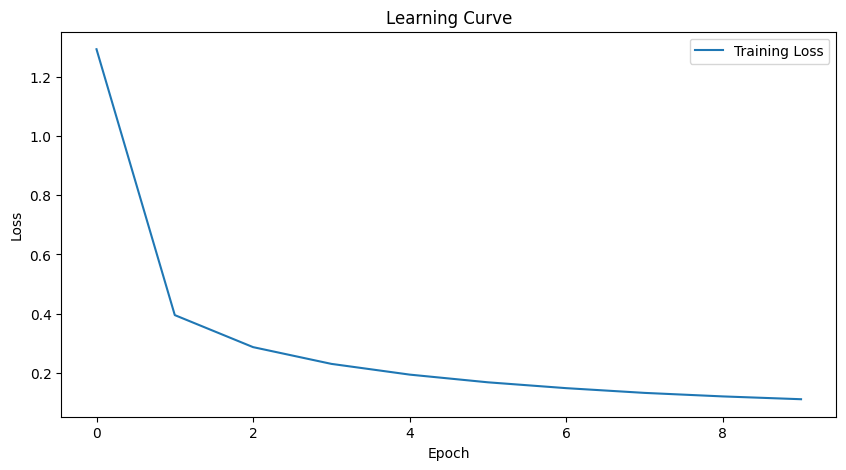

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt

# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Data loaders
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=4)

# Neural network class
class NetworkForPredictiveCoding(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, num_layers):
        super(NetworkForPredictiveCoding, self).__init__()
        self.numlayers = num_layers
        self.variance = [1.0] * self.numlayers
        self.inference_beta_parameter = 0.05
        self.max_iterations = 10
        self.threshold_option = 0.01
        self.device = device

        self.layers = nn.ModuleList()
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            nn.init.kaiming_normal_(self.layers[-1].weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = F.relu(self.layers[i](x))
        return self.layers[-1](x)

    def train_model(self, train_loader, epochs):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        training_losses = []
        for epoch in range(epochs):
            total_loss = 0
            for images, labels in train_loader:
                images, labels = images.view(images.size(0), -1).to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            average_loss = total_loss / len(train_loader)
            training_losses.append(average_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {average_loss}')
        return training_losses

    def evaluate_model(self, test_loader):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.view(images.size(0), -1).to(self.device), labels.to(self.device)
                outputs = self.forward(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
        return accuracy

# Initialize the model
model = NetworkForPredictiveCoding(input_size=784, hidden_sizes=[32, 16], output_size=10, num_layers=3).to(device)

# Train and evaluate the model
train_losses = model.train_model(train_loader, epochs=10)
test_accuracy = model.evaluate_model(test_loader)

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Train on MNIST dataset